In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json
import os
import shutil 
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import cv2

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt

from itertools import combinations

In [2]:
df = pd.read_csv('df_total.csv', index_col=0)
df['gender'] = df['gender'].fillna('Мужской')
cols = ['Асимметрия челюсти', 'Высота бровей', 'Наклон глаз',
       'Полнота верхней губы', 'Полнота нижней губы',
       'Асимметрия размера глаз', 'Ширина посадки глаз', 'Скулы',
       'Форма головы', 'Верхнее веко', 'Асимметрия брови', 'Наклон бровей',
       'Размер рта', 'Асимметрия наклона глаз', 'Асимметрия носа',
       'Размер глаз', 'Оттопыренность ушей', 'Ширина челюсти', 'Уголки рта',
       ]

for col in tqdm(cols):
    df[col] = (df[col] - df[col].quantile(0.01)) / (df[col].quantile(0.99) - df[col].quantile(0.001))
    
df['Категория'] = df['fraud'].replace({True: 'Мошенник', False: 'Не мошенник'})
features = ['Асимметрия челюсти', 'Высота бровей', 'Наклон глаз',
           'Полнота верхней губы', 'Полнота нижней губы',
           'Асимметрия размера глаз', 'Ширина посадки глаз', 'Скулы',
           'Форма головы', 'Верхнее веко', 'Асимметрия брови', 'Наклон бровей',
           'Размер рта', 'Асимметрия наклона глаз', 'Асимметрия носа',
           'Размер глаз', 'Оттопыренность ушей', 'Ширина челюсти', 'Уголки рта',
           ]

anketas = ['source', 'childs', 'education', 'marital_status', 'job']

ga = ['age', 'gender']

/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [18]:
from sklearn.model_selection import StratifiedKFold 

def train_model(df, cols, folds, iterations, depth, learning_rate ):
#                 depth, colsample_bylevel, subsample, bagging_temperature, random_strength, l2_leaf_reg):
    
    X = df[cols]
    cat_features = X.select_dtypes('object').columns.tolist()
    y = df['Категория']

    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=6)
    staged_probas_df =  pd.DataFrame(np.zeros((X.shape[0],iterations)), index=X.index)

    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = CatBoostClassifier(iterations=iterations, 
                                   depth=depth,
                                   eval_metric='AUC',
#                                    learning_rate=learning_rate,
#                                    loss_function='Logloss',
                                   scale_pos_weight=3,
#                                    colsample_bylevel=0.5,
                                   subsample=0.5,
# #                                    bagging_temperature=bagging_temperature,
#                                    random_strength=random_strength,
#                                    l2_leaf_reg=l2_leaf_reg,
#                                    boosting_type='Plain', # 'Plain'
                                   bootstrap_type='Bernoulli',# 'Bernoulli' Bayesian
#                                    max_ctr_complexity=2,
                                   task_type='CPU',
                                  )

        model.fit(
            X_train, y_train,
            eval_set = (X_test, y_test),
            cat_features=cat_features,
            verbose=False,
            plot=True,
            use_best_model=False
        );

        staged_probas = model.staged_predict_proba(X_test)
        for i, staged_proba in enumerate(staged_probas):
            staged_probas_df.iloc[test_index, i] = staged_proba[:,1]
        
    return staged_probas_df, model


def get_result_table(y_proba):
    df['y_proba'] = y_proba

    quantiles = []
    step = 0.2

    df['target'] = df['Категория'] == 'Мошенник'

    for i in np.arange(0, 1+step, step):
        if i > 1: i = 1
        quant = df['y_proba'].quantile(i)
        quantiles.append(quant)

    profit_abs = []
    loaners_amount = []
    good_bad = []

    for i, quant in enumerate(quantiles):
        if i == 0: quant = 0
        i_next = i + 1
        if i_next == len(quantiles): i_next = len(quantiles) - 1
        q = df[(df['y_proba'] >= quant) & (df['y_proba'] < quantiles[i_next])]
        profit_abs.append(round(pd.Series(q['total_given'] - q['total_taken']).sum()/1000000, 5))
        loaners_amount.append(q.shape[0])
        good_bad.append(q['target'].mean()*100)
        i_old = quantiles[i-1]

    print(quantiles)
    df2 = pd.DataFrame()
    df2['y proba'] = quantiles # np.append(np.arange(0, 0.1, 0.02), 
    df2['Количество людей'] = loaners_amount
    df2['Процент людей, %'] = df2['Количество людей'] * 100 / df.shape[0]
    df2['Процент мошенников в группе, %'] = good_bad
    df2['Прибыль, млн.р'] = np.array(profit_abs)*2

    return df2.drop('Количество людей', axis=1)

In [19]:
staged_probas_df, model_KU = train_model(df=df, cols=features,
                                          folds = 4, iterations=500, \
                                          depth=4, learning_rate=0.01)

model_KU.get_feature_importance(prettified=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,Асимметрия челюсти,6.757134
1,Уголки рта,6.702688
2,Высота бровей,6.191836
3,Форма головы,5.945056
4,Размер рта,5.755232
5,Скулы,5.584645
6,Размер глаз,5.493714
7,Асимметрия размера глаз,5.479780
8,Полнота верхней губы,5.133719
9,Полнота нижней губы,5.027170


In [5]:
get_result_table(staged_probas_df[449])

[0.20485985954270877, 0.6397376268652318, 0.6816849390356298, 0.7136776283459549, 0.7538390090629146, 0.9252217285869704]


,y proba,"Процент людей, %","Процент мошенников в группе, %","Прибыль, млн.р"
0,0.204860,19.978166,35.154827,-1.06900
1,0.639738,20.026686,36.220472,-1.19720
2,0.681685,19.990296,33.798544,-1.63170
3,0.713678,20.002426,29.593693,0.14268
4,0.753839,19.966036,18.347509,0.55822
5,0.925222,0.000000,NaN,0.00000


/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


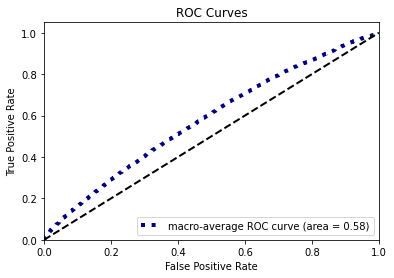

In [6]:
# Micro is shows more positive result
y_proba = staged_probas_df[499]
proba = np.array([y_proba, 1-y_proba])
skplt.metrics.plot_roc_curve(df['target'].astype(int).values, proba.T, curves=['macro'])
plt.show()

### Features + GA

In [7]:
staged_probas_df, model_KU = train_model(df=df, cols=features+ga,
                                          folds = 4, iterations=500, \
                                          depth=4, learning_rate=0.01)

model_KU.get_feature_importance(prettified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,Уголки рта,6.373067
1,Форма головы,6.237923
2,Асимметрия размера глаз,5.948338
3,Размер глаз,5.812953
4,Высота бровей,5.679823
5,age,5.562212
6,Размер рта,5.293193
7,Скулы,5.078813
8,Асимметрия челюсти,4.890666
9,Полнота нижней губы,4.851368


In [8]:
get_result_table(staged_probas_df[449])

[0.25861895385146916, 0.6406798371235605, 0.6807252379787619, 0.7129733890306887, 0.7548534546376183, 0.9146509088279516]


,y proba,"Процент людей, %","Процент мошенников в группе, %","Прибыль, млн.р"
0,0.258619,19.990296,36.650485,-1.51266
1,0.640680,20.002426,35.779260,-0.99184
2,0.680725,20.002426,32.565191,-1.07328
3,0.712973,19.978166,29.143898,-0.05634
4,0.754853,20.014556,19.030303,0.41094
5,0.914651,0.000000,NaN,0.00000


/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


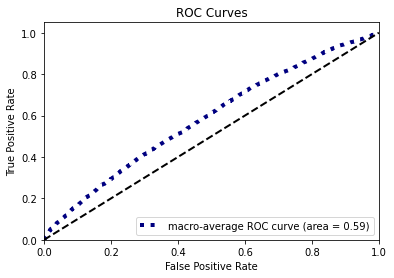

In [9]:
# Micro is shows more positive result
y_proba = staged_probas_df[499]
proba = np.array([y_proba, 1-y_proba])
skplt.metrics.plot_roc_curve(df['target'].astype(int).values, proba.T, curves=['macro'])
plt.show()

# Only GA

In [10]:
staged_probas_df, model_KU = train_model(df=df, cols=ga,
                                          folds = 4, iterations=500, \
                                          depth=4, learning_rate=0.01)

model_KU.get_feature_importance(prettified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,age,76.752473
1,gender,23.247527


In [11]:
get_result_table(staged_probas_df[499])

[0.18170331895160352, 0.6593427252617866, 0.6872407085732481, 0.7042800667618285, 0.7278090043274706, 0.9481413362030015]


,y proba,"Процент людей, %","Процент мошенников в группе, %","Прибыль, млн.р"
0,0.181703,19.553615,33.995037,-1.53554
1,0.659343,20.426977,32.125891,-0.79504
2,0.687241,19.978166,32.119004,-0.56748
3,0.704280,19.953906,29.179331,0.15996
4,0.727809,20.026686,25.863113,-0.48688
5,0.948141,0.000000,NaN,0.00000


/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


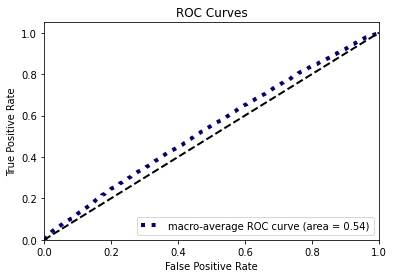

In [12]:
# Micro is shows more positive result
y_proba = staged_probas_df[499]
proba = np.array([y_proba, 1-y_proba])
skplt.metrics.plot_roc_curve(df['target'].astype(int).values, proba.T, curves=['macro'])
plt.show()

# Only anketas

In [13]:
staged_probas_df, model_KU = train_model(df=df, cols=anketas,
                                          folds = 4, iterations=500, \
                                          depth=4, learning_rate=0.01)

model_KU.get_feature_importance(prettified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,job,26.784758
1,marital_status,23.941376
2,education,23.412322
3,source,20.465700
4,childs,5.395843


In [14]:
get_result_table(staged_probas_df[499])

[0.35654798466870985, 0.6663509296404437, 0.6978745471342149, 0.7182912218030773, 0.740331577309612, 0.9463909472688156]


,y proba,"Процент людей, %","Процент мошенников в группе, %","Прибыль, млн.р"
0,0.356548,19.990296,38.956311,-2.04410
1,0.666351,19.953906,31.610942,-0.79218
2,0.697875,20.050946,30.611010,0.12534
3,0.718291,20.002426,28.320194,-0.58096
4,0.740332,19.966036,23.633050,0.07118
5,0.946391,0.000000,NaN,0.00000


/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


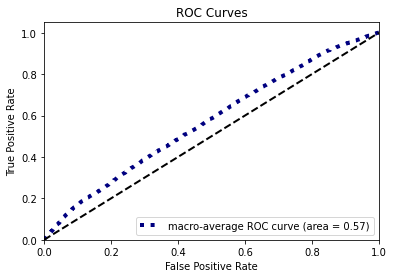

In [15]:
# Micro is shows more positive result
y_proba = staged_probas_df[499]
proba = np.array([y_proba, 1-y_proba])
skplt.metrics.plot_roc_curve(df['target'].astype(int).values, proba.T, curves=['macro'])
plt.show()

# All columns

In [20]:
staged_probas_df, model_KU = train_model(df=df, cols=features+ga+anketas,
                                          folds = 4, iterations=500, \
                                          depth=4, learning_rate=0.01)

model_KU.get_feature_importance(prettified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,Асимметрия челюсти,5.920313
1,Форма головы,5.666672
2,Высота бровей,5.585417
3,source,5.498239
4,Уголки рта,5.363011
5,Асимметрия наклона глаз,5.033915
6,Размер глаз,4.520743
7,Асимметрия размера глаз,4.369991
8,Асимметрия брови,4.187477
9,Размер рта,4.168456


In [21]:
get_result_table(staged_probas_df[499])

[0.2942319137322479, 0.8433804862567456, 0.8646397286468263, 0.8798078002269559, 0.894757159413457, 0.9583306131282057]


,y proba,"Процент людей, %","Процент мошенников в группе, %","Прибыль, млн.р"
0,0.294232,20.002426,37.052759,-1.71854
1,0.843380,20.002426,33.959976,-0.69226
2,0.864640,19.990296,33.313107,-0.84342
3,0.879808,19.966036,29.040097,-0.60282
4,0.894757,20.002426,19.769557,0.66002
5,0.958331,0.000000,NaN,0.00000


/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


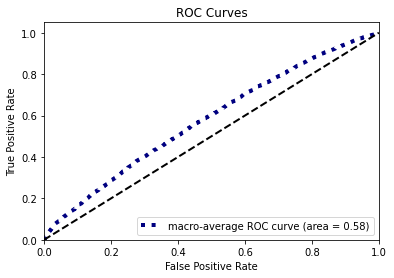

In [22]:
# Micro is shows more positive result
y_proba = staged_probas_df[499]
proba = np.array([y_proba, 1-y_proba])
skplt.metrics.plot_roc_curve(df['target'].astype(int).values, proba.T, curves=['macro'])
plt.show()

# Try with LinearRegression

In [27]:
df['gender'] = df['gender'].replace({'Мужской': 1, 'Женский': 0})

/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

In

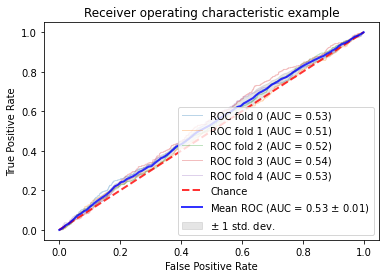

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from scipy import interp

n_samples, n_features = df.shape

cv = StratifiedKFold(n_splits=5)
classifier = LogisticRegression(class_weight ='balanced', C=2.0, penalty='l2', solver='lbfgs')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
columns = features+ga#+anketas

i = 0
X, y = df[columns].values, df['target'].values
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [24]:
columns

['Асимметрия челюсти',
 'Высота бровей',
 'Наклон глаз',
 'Полнота верхней губы',
 'Полнота нижней губы',
 'Асимметрия размера глаз',
 'Ширина посадки глаз',
 'Скулы',
 'Форма головы',
 'Верхнее веко',
 'Асимметрия брови',
 'Наклон бровей',
 'Размер рта',
 'Асимметрия наклона глаз',
 'Асимметрия носа',
 'Размер глаз',
 'Оттопыренность ушей',
 'Ширина челюсти',
 'Уголки рта',
 'age',
 'gender',
 'source',
 'childs',
 'education',
 'marital_status',
 'job']